In [1]:
# This is to ensure that the IERS data is not downloaded automatically by Astropy, which can cause cache issues with muli-processing
from astropy.utils import iers
iers.conf.auto_download = False
iers.conf.iers_degraded_accuracy = "warn"

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import sys
sys.path.append('../')
import h5py
import pandas as pd
import os
import numpy as np
import pylab as plt
from glob import glob
from tqdm import tqdm
import seaborn as sns
from scipy.stats import ncx2
from pesummary.gw.conversions.spins import spin_angles
from GWFish.modules.detection import Network
from GWFish.modules.fishermatrix import compute_network_errors
import GWFish.modules as gwf_mods
import pathlib
from utils import get_detected_SNRs, load_results_from_h5

## Get injection data SNRs

In [2]:
#base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
base_dir = '/home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/'
inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
                             'CE4020ET123_CoBA10_SNR_5_pop_PLP_spin_prec_fref_5_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5')
#inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
#                             'LHI_SNR_2_pop_PLP_spin_prec_fref_10_z_MD_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5')

In [3]:
inj_data = load_results_from_h5(inj_data_file)

In [4]:
pd.DataFrame(inj_data['results'])

,PSD_C1,PSD_CE20,PSD_E1,PSD_E2,PSD_E3,SNR_C1,SNR_CE20,SNR_E1,SNR_E2,SNR_E3,...,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,theta_jn,time_interval,trigger_time
0,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,26.890906,6.082231,11.573002,8.443707,4.183591,...,-0.151343,0.368443,0.336128,8.354979,6.641341,6.476252,14.996320,1.387950,2397.357958,1.893026e+09
1,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,30.923279,19.586402,8.216392,6.510056,6.628056,...,0.215131,-0.265249,0.083893,20.416446,8.293748,11.107885,28.710194,2.107388,40.357782,1.893026e+09
2,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,134.790289,58.389802,56.626102,57.878911,53.428096,...,-0.147023,-0.734618,0.526370,12.559317,8.447756,8.932054,21.007074,2.764603,139.074145,1.893027e+09
3,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,24.422831,10.987275,3.875804,5.155366,2.734553,...,0.428761,0.145118,-0.203761,10.836214,10.812505,9.423146,21.648719,1.366520,452.588451,1.893027e+09
4,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,22.438899,13.035350,10.440927,5.772831,5.237144,...,0.270313,0.499474,0.021336,17.554939,8.807417,10.699214,26.362356,2.334330,1334.041940,1.893028e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22755,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,60.338039,45.030861,20.728980,23.342237,24.073963,...,0.527377,-0.601355,-0.350036,7.922638,3.637087,4.604523,11.559725,2.523197,231.780097,1.924435e+09
22756,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,29.317528,17.671699,24.934851,22.595010,25.361612,...,0.010737,0.205612,-0.075798,30.715894,30.538703,26.662478,61.254596,1.005110,136.159327,1.924435e+09
22757,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,37.008786,17.526966,11.016267,14.723909,4.339288,...,0.029080,-0.001921,-0.040690,31.189314,24.274139,23.915993,55.463453,1.582021,2736.237313,1.924438e+09
22758,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,19.560080,16.292502,2.972777,5.018630,2.061012,...,0.105120,0.728601,-0.158751,11.143133,8.132996,8.267054,19.276129,1.515721,439.822230,1.924438e+09


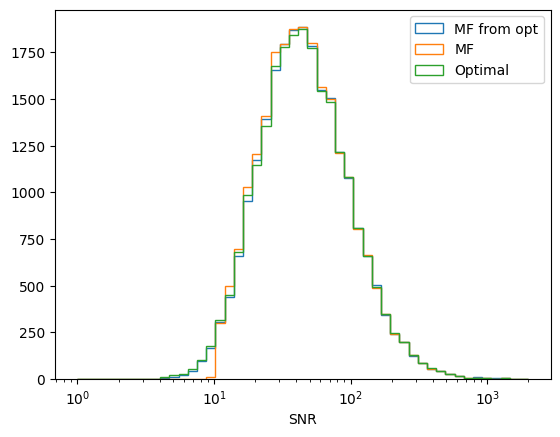

In [5]:
plt.hist(inj_data['results']['SNR_mf_from_opt_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='MF from opt');
plt.hist(inj_data['results']['SNR_mf_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='MF');
plt.hist(inj_data['results']['SNR_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='Optimal');
plt.xlabel('SNR')
plt.legend()
plt.xscale('log')

### Get detected

In [6]:
inj_data['detected'] = get_detected_SNRs(inj_data['results'], method='network', 
                                         snr_type='opt', network_threshold=10)

['SNR_C1', 'SNR_CE20', 'SNR_E1', 'SNR_E2', 'SNR_E3', 'SNR_network']


### Detected percentage

In [7]:
n_total = len(inj_data['results']['redshift'])
#n_detected = len(inj_data['detected_mf_from_opt']['redshift'])
n_detected = len(inj_data['detected']['redshift'])

print('Total =', n_total)
print('detected =', n_detected, '=', round(n_detected*100/n_total, 1), '%')

Total = 22760
detected = 22393 = 98.4 %


### Choose n_events from detected as injection parameters

In [24]:
n_events = 4000
#n_events = len(inj_data['detected']['redshift'])
inj_data['selected_n_events'] = inj_data['detected'].sample(n_events, random_state=128).reset_index().rename(columns={'index': 'old_index'})
#inj_data['selected_n_events'].insert(5, 'SNR_ET', np.sqrt(inj_data['selected_n_events']['SNR_E1']**2 + inj_data['selected_n_events']['SNR_E2']**2 + inj_data['selected_n_events']['SNR_E3']**2))
#inj_data['selected_n_events'] = inj_data['detected_mf'].iloc[:n_events]

Text(0.5, 0, 'z')

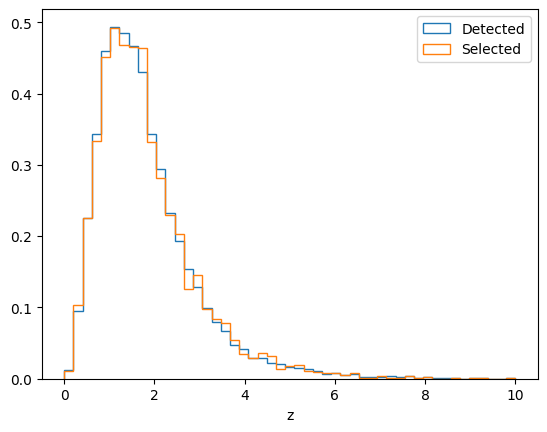

In [25]:
plt.hist(inj_data['detected']['redshift'], density=True, histtype=u'step', bins=np.linspace(0,10,50), 
         label='Detected')
plt.hist(inj_data['selected_n_events']['redshift'], density=True, histtype=u'step', 
         bins=np.linspace(0,10,50), label='Selected');
plt.legend()
plt.xlabel('z')

In [26]:
len(inj_data['selected_n_events']['redshift'])

4000

## FM analysis with GWFish

In [27]:
inj_data['selected_n_events'].keys()

Index(['old_index', 'PSD_C1', 'PSD_CE20', 'PSD_E1', 'PSD_E2', 'PSD_E3',
       'SNR_C1', 'SNR_CE20', 'SNR_E1', 'SNR_E2', 'SNR_E3', 'SNR_mf_C1',
       'SNR_mf_CE20', 'SNR_mf_E1', 'SNR_mf_E2', 'SNR_mf_E3',
       'SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1',
       'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network',
       'SNR_mf_network', 'SNR_network', 'approximant', 'chi_1_in_plane',
       'chi_2_in_plane', 'chi_eff', 'chi_p', 'coa_phase', 'cos_spin1_polar',
       'cos_spin2_polar', 'dec', 'delta_f', 'distance', 'eta', 'f_final',
       'f_lower', 'f_ref', 'inclination', 'mass1', 'mass2', 'mchirp', 'mtotal',
       'phi_12', 'phi_jl', 'polarization', 'q', 'ra', 'redshift', 'spin1_a',
       'spin1_azimuthal', 'spin1_polar', 'spin1x', 'spin1y', 'spin1z',
       'spin2_a', 'spin2_azimuthal', 'spin2_polar', 'spin2x', 'spin2y',
       'spin2z', 'srcmass1', 'srcmass2', 'srcmchirp', 'srcmtotal', 'theta_jn',
       'time_interval', 'trigger_time']

In [28]:
pycbc_to_pesummary_map = {
    'mchirp': 'chirp_mass',
    'q': 'mass_ratio',
    'distance': 'luminosity_distance',
    'theta_jn': 'theta_jn',
    'ra': 'ra',
    'dec': 'dec',
    'polarization': 'psi',
    'trigger_time': 'geocent_time',
    'coa_phase': 'phase',
    'spin1_a': 'a_1',
    'spin2_a': 'a_2',
    'spin1_polar': 'tilt_1',
    'spin2_polar':'tilt_2',
    'phi_12': 'phi_12',
    'phi_jl': 'phi_jl',
    'mass1': 'mass_1',
    'mass2': 'mass_2'
}
#gwfish_det_dict = {'L1':'L', 'H1':'H', 'I1':'IN'}

In [29]:
gwfish_input_data = {pycbc_to_pesummary_map[key]:inj_data['selected_n_events'][key] for key in pycbc_to_pesummary_map.keys() if key != 'q'}
gwfish_input_data = pd.DataFrame(gwfish_input_data)
gwfish_input_data['mass_ratio'] = 1/inj_data['selected_n_events']['q']

In [30]:
gwfish_input_data

,chirp_mass,luminosity_distance,theta_jn,ra,dec,psi,geocent_time,phase,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,mass_1,mass_2,mass_ratio
0,79.156787,15337.661200,1.092353,0.804861,-0.568115,2.036163,1.917509e+09,5.707401,0.687008,0.386084,1.708385,2.014412,6.027141,1.451298,95.400694,86.703203,0.908832
1,17.172977,2929.186444,2.072201,1.389595,0.109868,1.160423,1.924372e+09,5.193551,0.153043,0.087826,0.754336,0.706341,1.711492,1.474362,21.786795,17.895713,0.821402
2,33.672474,6895.997560,0.732344,0.225244,-0.186255,2.751015,1.895507e+09,2.495540,0.433754,0.309670,1.439791,1.073390,0.317022,2.208563,51.638525,29.428334,0.569891
3,32.245915,28511.018676,1.039117,3.129349,0.092610,2.565347,1.909335e+09,1.197497,0.417339,0.403094,1.481971,0.522870,2.626897,5.779146,40.285605,34.104623,0.846571
4,46.961825,10696.451105,2.846159,0.864480,0.142680,1.048749,1.901310e+09,1.765143,0.576836,0.038969,2.078625,2.340282,3.026965,5.345052,57.321546,50.804265,0.886303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,54.996784,5595.069977,0.798604,4.857763,0.446677,1.046542,1.896758e+09,3.357013,0.771653,0.668084,1.647965,0.628910,2.129071,0.756880,63.235779,63.113721,0.998070
3996,15.911206,3034.698183,2.517031,0.935475,-0.035834,2.216320,1.911398e+09,1.129593,0.135794,0.271871,1.862536,1.907132,4.152499,4.475812,28.756055,12.050934,0.419075
3997,42.191555,40335.902885,1.505361,6.225869,-0.796010,2.460441,1.918387e+09,4.440997,0.508364,0.097493,1.847922,1.050219,0.967074,2.841473,50.934522,46.138462,0.905839
3998,13.480441,3063.668147,0.240778,3.071665,-0.226694,0.963150,1.907841e+09,1.061364,0.020605,0.297635,2.156455,0.528283,6.151045,2.843097,16.207320,14.800891,0.913223


In [31]:
file_str = inj_data_file.split('/')[-1]
for repl_tup in [('_pop_PLP', '_PLP'), 
                 ('_SNR', ''), 
                 ('_spin_prec', ''), 
                 ('_fref_5', ''), 
                 ('_365_days_corrected_td_data.h5', '')]:
    file_str = file_str.replace(repl_tup[0], repl_tup[1])
file_str

'CE4020ET123_CoBA10_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22'

In [32]:
if 'set' in file_str:
    set_num = file_str.split('set')[-1].split('_')[0]
    file_str = file_str.replace('pop_', '').replace('set'+set_num+'_', '').replace('PLP_', 'PLP_set'+set_num+'_')
file_str

'CE4020ET123_CoBA10_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22'

In [33]:
if 'CE4020ET123' in file_str:
    detectors = ['CE1', 'CE2', 'ET']
elif 'LHI' in file_str:
    detectors = ['A_sharp_L', 'A_sharp_H', 'A_sharp_IN']
matrix_file_names = f'{file_str}_no_spins_{n_events}_events_pop_from_XPHM_det10_opt_netw'
#matrix_file_names = f'LHI_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_{n_events}_events_pop_from_XPHM_det10_opt'
print(detectors)
print(matrix_file_names)

['CE1', 'CE2', 'ET']
CE4020ET123_CoBA10_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_4000_events_pop_from_XPHM_det10_opt_netw


### Without parallelization

In [19]:
results = {'detected_idxs':[], 
           'netw_snrs':[], 
           'errors':[],
           'sky_locs':[]}
fisher_params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'phase', 'geocent_time', 'ra', 'dec', 'psi']
network = gwf_mods.detection.Network(detector_ids = detectors, detection_SNR = (0., 5.), config=pathlib.Path('detectors.yaml'))
#for event_num in tqdm(range(len(inj_data['selected_n_events']))):
results['detected_idxs'], results['netw_snrs'], results['errors'], results['sky_locs'] = compute_network_errors(
    network=network, 
    parameter_values=gwfish_input_data,
    fisher_parameters=fisher_params, 
    f_ref=inj_data['selected_n_events']['f_ref'][0], 
    waveform_model='IMRPhenomXPHM',
    save_matrices=True,
    save_matrices_path=pathlib.Path(os.path.join(base_dir, 
                                                 'GWFish_analysis', 
                                                 'BBH',
                                                 'Fisher_matrices')),
    matrix_naming_postfix=matrix_file_names
)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 4/5000 [00:05<1:52:56,  1.36s/it]


KeyboardInterrupt: 

### With parallelization

In [34]:
nprocs = 32
from gwfish_functions import parallel_compute_network_errors, combine_and_archive_fisher_matrices

In [35]:
fisher_params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'phase', 'geocent_time', 'ra', 'dec', 'psi']
network = gwf_mods.detection.Network(detector_ids = detectors, detection_SNR = (0., 1.), config=pathlib.Path('detectors.yaml'))
results = {}
results['detected_idxs'], results['netw_snrs'], results['errors'], results['sky_locs'] = (
    parallel_compute_network_errors(
        network=network,
        gwfish_input_data=gwfish_input_data,
        fisher_params=fisher_params,
        f_ref=inj_data['selected_n_events']['f_ref'][0],
        base_dir=base_dir,
        matrix_file_names=matrix_file_names,
        nproc=nprocs
    )
)

100%|██████████| 125/125 [07:25<00:00,  3.56s/it]


In [36]:
combine_and_archive_fisher_matrices(
    base_dir=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices'),
    matrix_file_prefix=f'fisher_matrices_{matrix_file_names}',
    n_chunks=nprocs,
    output_file=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices', f'fisher_matrices_{matrix_file_names}.npy')
)

combine_and_archive_fisher_matrices(
    base_dir=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices'),
    matrix_file_prefix=f'inv_fisher_matrices_{matrix_file_names}',
    n_chunks=nprocs,
    output_file=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices', f'inv_fisher_matrices_{matrix_file_names}.npy')
)

Combined Fisher matrices saved to /home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/fisher_matrices_CE4020ET123_CoBA10_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_4000_events_pop_from_XPHM_det10_opt_netw.npy
Moved 32 chunked Fisher matrix files to /home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/chunks
Combined Fisher matrices saved to /home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/inv_fisher_matrices_CE4020ET123_CoBA10_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_4000_events_pop_from_XPHM_det10_opt_netw.npy
Moved 32 chunked Fisher matrix files to /home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/chunks


In [37]:
results['errors'] = pd.DataFrame(results['errors'], columns=fisher_params)
results['errors']

,chirp_mass,mass_ratio,luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
0,0.001314,0.025457,354.384651,0.017677,0.035021,0.000329,0.020447,0.016358,0.019842
1,0.000146,0.003493,62.551314,0.016649,0.048237,0.000148,0.004653,0.009844,0.021124
2,0.001963,0.001311,178.167936,0.026677,0.176710,0.000227,0.003303,0.014905,0.087669
3,0.002426,0.014511,4742.383575,0.136173,0.375950,0.001092,0.008466,0.088074,0.184235
4,0.000236,0.004024,127.714323,0.033613,2.046652,0.000084,0.003085,0.008281,1.024755
...,...,...,...,...,...,...,...,...,...
3995,0.000118,0.000014,71.516531,0.013966,0.058048,0.000066,0.003840,0.003199,0.028178
3996,0.000129,0.000301,54.600095,0.024940,0.258252,0.000086,0.003227,0.006247,0.127463
3997,0.012920,0.025391,2691.127478,0.056994,0.199994,0.000389,0.021922,0.055762,0.056805
3998,0.000055,0.001210,84.060274,0.117640,15.118031,0.000032,0.001279,0.003334,7.559936


### Add original parameters to the results dict

In [38]:
results['all_inj_params_original'] = inj_data['selected_n_events']
results['all_inj_params_original'].loc[:,'log_distance'] = np.log(results['all_inj_params_original']['distance'])
results['all_inj_params_original'].loc[:, 'inv_q'] = 1/results['all_inj_params_original']['q']

In [39]:
results['deriv_variables_in_order'] = np.array(results['errors'].keys(), dtype=h5py.string_dtype(encoding='utf-8'))
results['deriv_variables_in_order']

array(['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn',
       'phase', 'geocent_time', 'ra', 'dec', 'psi'], dtype=object)

In [40]:
pesummary_to_pycbc_map = {
    'chirp_mass':'mchirp',
    'mass_ratio':'inv_q',
    'luminosity_distance':'distance',
    'theta_jn':'theta_jn',
    'phase':'coa_phase',
    'geocent_time':'trigger_time',
    'ra':'ra',
    'dec':'dec',
    'psi':'polarization'
}

In [41]:
results['inj_params'] = pd.DataFrame({key:results['all_inj_params_original'][pesummary_to_pycbc_map[key]] for key in results['deriv_variables_in_order']})
results['inj_params']

,chirp_mass,mass_ratio,luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
0,79.156787,0.908832,15337.661200,1.092353,5.707401,1.917509e+09,0.804861,-0.568115,2.036163
1,17.172977,0.821402,2929.186444,2.072201,5.193551,1.924372e+09,1.389595,0.109868,1.160423
2,33.672474,0.569891,6895.997560,0.732344,2.495540,1.895507e+09,0.225244,-0.186255,2.751015
3,32.245915,0.846571,28511.018676,1.039117,1.197497,1.909335e+09,3.129349,0.092610,2.565347
4,46.961825,0.886303,10696.451105,2.846159,1.765143,1.901310e+09,0.864480,0.142680,1.048749
...,...,...,...,...,...,...,...,...,...
3995,54.996784,0.998070,5595.069977,0.798604,3.357013,1.896758e+09,4.857763,0.446677,1.046542
3996,15.911206,0.419075,3034.698183,2.517031,1.129593,1.911398e+09,0.935475,-0.035834,2.216320
3997,42.191555,0.905839,40335.902885,1.505361,4.440997,1.918387e+09,6.225869,-0.796010,2.460441
3998,13.480441,0.913223,3063.668147,0.240778,1.061364,1.907841e+09,3.071665,-0.226694,0.963150


In [42]:
load_inv_matrices = np.load(os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices', 
                                         f'inv_fisher_matrices_{matrix_file_names}.npy'))

In [43]:
len(load_inv_matrices)

4000

In [44]:
results['cov'] = load_inv_matrices

## Sanity checks

### Check if cov matrices are positive-definite

In [45]:
failed = []
for event in range(len(results['all_inj_params_original'])):
    cov = load_inv_matrices[event]  # the covariance matrix
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        failed.append(event)

In [46]:
failed

[3539, 3959]

In [47]:
failed_dict = {}
if len(failed) !=0:
    failed_dict['inj_params'] = results['inj_params'].loc[failed]
    failed_dict['all_inj_params_original'] = results['all_inj_params_original'].loc[failed]

In [48]:
failed_dict['inj_params']

,chirp_mass,mass_ratio,luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
3539,10.138478,0.529019,5435.393128,3.038886,5.453844,1.916728e+09,4.668060,-0.380413,3.128227
3959,29.225502,0.879770,32879.437018,0.081795,0.403666,1.921757e+09,3.149577,-0.291499,2.412508


In [49]:
print(len(results['inj_params']))

4000


In [50]:
results.keys()

dict_keys(['detected_idxs', 'netw_snrs', 'errors', 'sky_locs', 'all_inj_params_original', 'deriv_variables_in_order', 'inj_params', 'cov'])

In [51]:
[(key, type(results[key])) for key in results.keys()]

[('detected_idxs', numpy.ndarray),
 ('netw_snrs', numpy.ndarray),
 ('errors', pandas.core.frame.DataFrame),
 ('sky_locs', numpy.ndarray),
 ('all_inj_params_original', pandas.core.frame.DataFrame),
 ('deriv_variables_in_order', numpy.ndarray),
 ('inj_params', pandas.core.frame.DataFrame),
 ('cov', numpy.ndarray)]

In [52]:
results_updated = {}
for key in results.keys():
    if key == 'detected_idxs':
        continue
    if key == 'deriv_variables_in_order':
        results_updated[key] = results[key]
    else:
        if len(failed) == 0:
            print("No failed events")
            results_updated[key] = results[key]
        else:
            if isinstance(results[key], pd.DataFrame):
                results_updated[key] = results[key].drop(index=failed)
            elif isinstance(results[key], np.ndarray):
                results_updated[key] = np.array([results[key][i] for i in range(len(results[key])) if i not in failed])

In [53]:
print(len(results_updated['inj_params']))

3998


### Check for positive-definite again

In [54]:
failed2 = []
for event in range(len(results_updated['all_inj_params_original'])):
    cov = results_updated['cov'][event]  # the covariance matrix
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        failed2.append(event)

In [55]:
failed2

[]

In [56]:
results.keys()

dict_keys(['detected_idxs', 'netw_snrs', 'errors', 'sky_locs', 'all_inj_params_original', 'deriv_variables_in_order', 'inj_params', 'cov'])

### DL errors are reasonable

Text(0.5, 0, '$\\Delta D_L / D_L$')

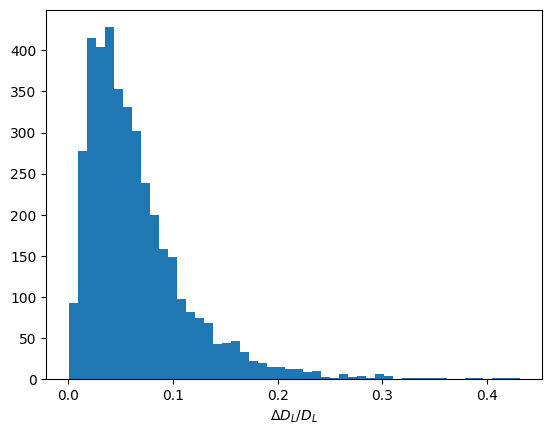

In [57]:
plt.hist(results_updated['errors']['luminosity_distance']/results_updated['all_inj_params_original']['distance'], bins=50);
plt.xlabel('$\Delta D_L / D_L$')

Text(0.5, 0, 'Network SNR')

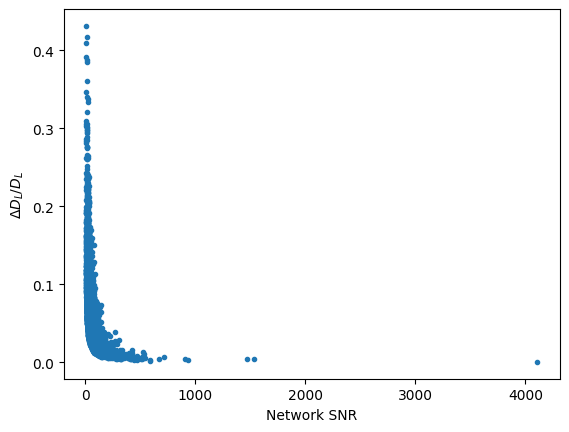

In [58]:
plt.plot(results_updated['netw_snrs'], 
         results_updated['errors']['luminosity_distance']/results_updated['all_inj_params_original']['distance'], '.')
plt.ylabel('$\Delta D_L / D_L$')
plt.xlabel('Network SNR')

### Check the recomibing has not messed up matrix orders

In [59]:
dl_idx = list(results_updated['errors'].keys()).index('luminosity_distance')
dl_idx

2

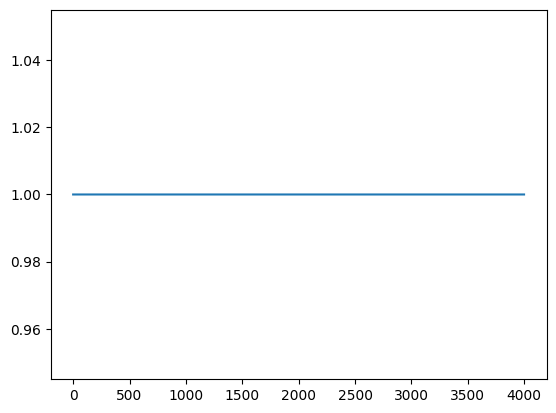

In [60]:
dl_errs_from_covs = [np.sqrt(cov[dl_idx, dl_idx]) for cov in results_updated['cov']]
plt.plot(results_updated['errors']['luminosity_distance']/dl_errs_from_covs)

### Check SNRs are matching with injected

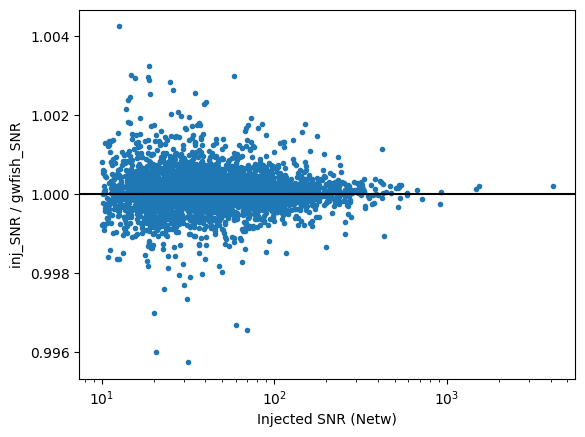

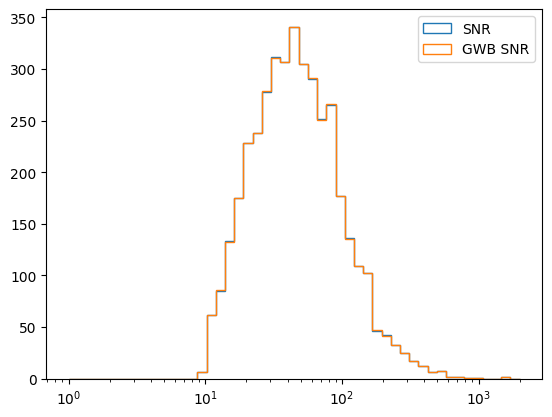

In [61]:
inj_snrs = results_updated['all_inj_params_original']['SNR_network']
gwfish_snrs = results_updated['netw_snrs']

plt.figure()
plt.plot(inj_snrs, inj_snrs/gwfish_snrs, '.')
plt.xlabel('Injected SNR (Netw)')
plt.ylabel('inj_SNR / gwfish_SNR')
plt.axhline(1, c='k')
plt.xscale('log')

plt.figure()
plt.hist(inj_snrs, bins=np.logspace(0,3.3,50), histtype=u'step', label='SNR');
plt.hist(gwfish_snrs, bins=np.logspace(0,3.3,50), histtype=u'step', label='GWB SNR');
plt.legend()
plt.xscale('log')

## Save to h5 file

### Write to file

In [62]:
print(results_updated.keys())
[type(results_updated[key]) for key in results_updated.keys()]

dict_keys(['netw_snrs', 'errors', 'sky_locs', 'all_inj_params_original', 'deriv_variables_in_order', 'inj_params', 'cov'])


[numpy.ndarray,
 pandas.core.frame.DataFrame,
 numpy.ndarray,
 pandas.core.frame.DataFrame,
 numpy.ndarray,
 pandas.core.frame.DataFrame,
 numpy.ndarray]

In [63]:
inj_data_file.split('/')[-1]

'CE4020ET123_CoBA10_SNR_5_pop_PLP_spin_prec_fref_5_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5'

In [64]:
file_str

'CE4020ET123_CoBA10_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22'

In [65]:
results_file = os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Errors',
                            f'{file_str}_no_spins_{len(results_updated["errors"])}_events_pop_from_XPHM_det10_opt_netw.h5')
#results_file = os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Errors',
#                            f'LHI_Asharp_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_{len(results_updated["errors"])}_events_365_days_pop_from_XPHM_det10.h5')
results_file = results_file.replace('_fref_10', '').replace('LHI_', 'LHI_Asharp_')
results_file

'/home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/CE4020ET123_CoBA10_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_3998_events_pop_from_XPHM_det10_opt_netw.h5'

In [66]:
from utils import save_results_to_h5
save_results_to_h5(results_updated, results_file)

## Check that the file was saved properly

In [67]:
with h5py.File(results_file, 'r') as f:
    print(f.keys())
    print(f['errors'].keys())
    print(f['deriv_variables_in_order'][()])
    print(f['netw_snrs'][()])
    print(f['all_inj_params_original'].keys())

<KeysViewHDF5 ['all_inj_params_original', 'cov', 'deriv_variables_in_order', 'errors', 'inj_params', 'netw_snrs', 'sky_locs']>
<KeysViewHDF5 ['chirp_mass', 'dec', 'geocent_time', 'luminosity_distance', 'mass_ratio', 'phase', 'psi', 'ra', 'theta_jn']>
[b'chirp_mass' b'mass_ratio' b'luminosity_distance' b'theta_jn' b'phase'
 b'geocent_time' b'ra' b'dec' b'psi']
[ 72.56047628 168.27638419 116.56133953 ...  18.28479711 267.17411112
  96.57914792]
<KeysViewHDF5 ['PSD_C1', 'PSD_CE20', 'PSD_E1', 'PSD_E2', 'PSD_E3', 'SNR_C1', 'SNR_CE20', 'SNR_E1', 'SNR_E2', 'SNR_E3', 'SNR_mf_C1', 'SNR_mf_CE20', 'SNR_mf_E1', 'SNR_mf_E2', 'SNR_mf_E3', 'SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1', 'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network', 'SNR_mf_network', 'SNR_network', 'approximant', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'coa_phase', 'cos_spin1_polar', 'cos_spin2_polar', 'dec', 'delta_f', 'distance', 'eta', 'f_final', 'f_lower', 'f_ref', 'incl